In [1]:
import math
import matplotlib.pylab as plt
import numpy as np
import os
import pandas as pd
import pathlib
import PIL
import PIL.Image
import plotly.graph_objects as go
import seaborn as sns
import shutil
import tensorflow as tf
import keras
import warnings

from distutils.dir_util import copy_tree
from IPython.display import Image
from random import sample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

warnings.filterwarnings('ignore')

In [2]:
dataset_path = "C:\\Users\Administrator\Desktop\Cacao Detect\cacao_photos"

In [3]:
Size=32

In [4]:
black_pod_count = os.listdir(dataset_path+"/black_pod_rot")
print(f"Black Pod Rot : {len(black_pod_count)}")
healthy_count = os.listdir(dataset_path+"/healthy")
print(f"Healthy : {len(healthy_count)}")
pod_borer_count = os.listdir(dataset_path+"/pod_borer")
print(f"Pod Borer : {len(pod_borer_count)}")

Black Pod Rot : 942
Healthy : 3343
Pod Borer : 102


In [5]:
# Create various directories for Model Building.

os.mkdir("train_photos")
os.mkdir("val_photos")
os.mkdir("augment_photos")
os.mkdir("best_models")

In [6]:
copy_tree(dataset_path, "train_photos")

['train_photos\\black_pod_rot\\black_pod_rot_1.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_10.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_100.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_101.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_102.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_103.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_104.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_105.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_106.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_107.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_108.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_109.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_11.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_110.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_111.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_112.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_113.jpg',
 'train_photos\\black_pod_rot\\black_pod_rot_114.jpg',
 'train_photos

In [9]:
image_path = "train_photos"

In [10]:
os.mkdir("val_photos/black_pod_rot")
os.mkdir("val_photos/healthy")
os.mkdir("val_photos/pod_borer")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'val_photos/black_pod_rot'

In [11]:
def move_num_of_files(count, lake_path, processed_path, count_end):
    try:
        images = os.listdir(lake_path)
        for file in images:
            if count < count_end:
                path = f"{lake_path}/{file}"
                shutil.move(path, processed_path)
                count += 1
    except Exception as e:
        print(e)

In [12]:
#Create validation set
black_pod_20 = math.ceil(len(black_pod_count)*0.20)
healthy_20 = math.ceil(len(healthy_count)*0.20)
pod_borer_20 = math.ceil(len(pod_borer_count)*0.20)

move_num_of_files(0, image_path+"/black_pod_rot", "./val_photos/black_pod_rot",black_pod_20)
move_num_of_files(0, image_path+"/healthy", "./val_photos/healthy",healthy_20)
move_num_of_files(0, image_path+"/pod_borer", "./val_photos/pod_borer",pod_borer_20)

In [13]:
#Data cleaning
black_pod_current_count = os.listdir(image_path+"/black_pod_rot")
healthy_current_count = os.listdir(image_path+"/healthy")
pod_borer_current_count = os.listdir(image_path+"/pod_borer")


healthy_path = image_path + "/healthy"
healthy = os.listdir(healthy_path)
for file in sample(healthy,(len(healthy_current_count)-len(black_pod_current_count))):
    os.remove(healthy_path+"/"+file)

In [14]:
!pip install Augmentor


In [15]:
import Augmentor

# Define augmentation pipelines.

pod_borer_augmentation_pipeline = Augmentor.Pipeline(source_directory=image_path+"/pod_borer", output_directory=image_path+"/pod_borer")

# Define different augmentations depending on the pipeline.

pod_borer_augmentation_pipeline.rotate(probability=0.6, max_left_rotation=10, max_right_rotation=10)
pod_borer_augmentation_pipeline.skew_top_bottom(0.3, 0.7)
pod_borer_augmentation_pipeline.skew_left_right(0.3, 0.7)
pod_borer_augmentation_pipeline.flip_random(0.3)

# Augment pod borer class.

pod_borer_augmentation_pipeline.sample(len(black_pod_current_count)-len(pod_borer_current_count))

Executing Pipeline:   0%|                                                                | 0/672 [00:00<?, ? Samples/s]

Initialised with 81 image(s) found.
Output directory set to train_photos/pod_borer\train_photos/pod_borer.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1080 at 0x171EF572040>: 100%|█| 672/672 [00:36<0


In [20]:
#Data Preparation
batch_size = 1
img_height = 224
img_width = 224
class_mode = "sparse"
epochs = 25

In [21]:
shutil.rmtree('./best_models')
os.mkdir("best_models")

In [22]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_path = "./train_photos"
val_path = "./val_photos"
valgen = tf.keras.preprocessing.image.ImageDataGenerator()

In [23]:
# Creation of Train and Validation sets in a format readable by the model.

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode,
)

val_generator = valgen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

Found 2259 images belonging to 3 classes.
Found 879 images belonging to 3 classes.


In [28]:
model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=train_generator.image_shape)
                                             
model.trainable = False
for layer in model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Adding 2 fully-connected layers.

x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = tf.keras.layers.Dense(3, activation="softmax")(x)
working_model = tf.keras.Model(inputs = model.input, outputs = predictions)
working_model.compile(loss=tf.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

# Defining callbacks.

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=6)
checkpoint_filepath = './best_models/Val_Loss.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                verbose=1,
                                                monitor='val_loss',
                                                save_best_only=True,
                                                mode='min')

# Display Model Configurations.
working_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
_______________________________________________________________________________________

In [29]:
#Model Training
model_history = working_model.fit(train_generator,
                                  epochs=epochs,
                                  callbacks=[early_stopping,
                                             checkpoint],
                                  validation_data=val_generator)

Epoch 1/25
2259/2259 [==============================] - ETA: 0s - loss: 0.3180 - sparse_categorical_accuracy: 0.8743
Epoch 00001: val_loss improved from inf to 0.39123, saving model to ./best_models\Val_Loss.h5
2259/2259 [==============================] - 440s 195ms/step - loss: 0.3180 - sparse_categorical_accuracy: 0.8743 - val_loss: 0.3912 - val_sparse_categorical_accuracy: 0.9022
Epoch 2/25
2259/2259 [==============================] - ETA: 0s - loss: 0.1340 - sparse_categorical_accuracy: 0.9566- ETA: 3s - loss: 0.1351 - sparse_catego
Epoch 00002: val_loss improved from 0.39123 to 0.10581, saving model to ./best_models\Val_Loss.h5
2259/2259 [==============================] - 422s 187ms/step - loss: 0.1340 - sparse_categorical_accuracy: 0.9566 - val_loss: 0.1058 - val_sparse_categorical_accuracy: 0.9590
Epoch 3/25
2259/2259 [==============================] - ETA: 0s - loss: 0.0781 - sparse_categorical_accuracy: 0.9757- ETA: 7s - lo
Epoch 00003: val_loss did not improve from 0.10581
22

In [30]:
best_models = tf.keras.models.load_model('./best_models/Val_Loss.h5')

In [31]:
val_predictions = best_models.predict(val_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)
val_classes = val_generator.classes
print(classification_report(val_classes,val_predicted_classes,target_names=["black pod rot", "healthy", "pod borer pest"]))

                precision    recall  f1-score   support

 black pod rot       0.97      0.85      0.90       189
       healthy       0.96      0.99      0.97       669
pod borer pest       0.91      0.95      0.93        21

      accuracy                           0.96       879
     macro avg       0.95      0.93      0.94       879
  weighted avg       0.96      0.96      0.96       879



In [32]:
# Define scatter plot visualization on plotly express.

def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss with respect to Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy with respect to Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Training"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Validation"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

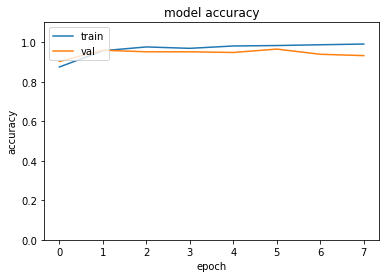

In [33]:
plt.plot(model_history.history['sparse_categorical_accuracy'])
plt.plot(model_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
display_training_curves(
    model_history.history['sparse_categorical_accuracy'], 
    model_history.history['val_sparse_categorical_accuracy'], 
    'accuracy')

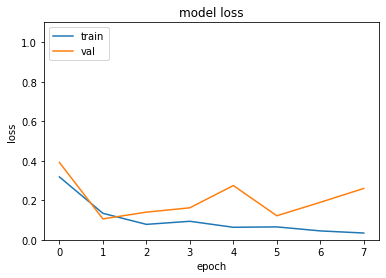

In [35]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
display_training_curves(
    model_history.history['loss'], 
    model_history.history['val_loss'], 
    'loss')

In [48]:
# Define layers for producing heat maps. 

last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "global_average_pooling2d",
    "dense",
]

In [49]:
# Define heatmap function helpers.

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [50]:
# Sort validation set classes into arrays. 

total_batch = val_generator.__len__()
val_generator.reset()
pod_borer_array = []
black_pod_array = []
healthy_array = []
for i in range (total_batch):
  x,y = val_generator.next()
  count = 0
  for label in y:
    if label == 2.0:
        pod_borer_array.append(x[count])
    elif label == 1.0:
        healthy_array.append(x[count])
    else:
        black_pod_array.append(x[count])
    count += 1

In [51]:
# Define heat map activation display in a graph.

def display_activation_graph(image_array, label):
    
    # display predictions on validation set
    plt.figure(figsize=(10,10)) # specifying the overall grid size
    correct = 0
    for i in range(20):
        plt.subplot(4,5,i+1)    # the number of images in the grid is 4*5 (25)
        pil_img = tf.keras.preprocessing.image.array_to_img(image_array[i])
        plt.imshow(pil_img)
        inference = best_models.predict( np.array( [image_array[i],] )  )
        verdict = np.argmax(inference[0])
        if verdict == label:
          correct += 1
        plt.title(f"{label} == {verdict}")
    plt.suptitle(f"Model Prediction on Validation Set \n {correct}/20 Correct")
    plt.show()


    # display heatmap
    plt.figure(figsize=(10,10)) # specifying the overall grid size
    correct = 0
    for i in range(20):
        plt.subplot(4,5,i+1)    # the number of images in the grid is 4*5 (25)
        pil_img = tf.keras.preprocessing.image.array_to_img(image_array[i])
        inference = best_models.predict( np.array( [image_array[i],] )  )
        heatmap = make_gradcam_heatmap(np.array( [image_array[i],] ),
                                       best_models,
                                       last_conv_layer_name,
                                       classifier_layer_names)
        img = image_array[i]
        heatmap = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
        superimposed_img = jet_heatmap * 0.4 + img
        superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
        plt.imshow(superimposed_img)
        verdict = np.argmax(inference[0])
        if verdict == label:
          correct += 1
        plt.title(f"{label} == {verdict}")
    plt.suptitle(f"Heat Map Representation \n {correct}/20 Correct")
    plt.show()
    
    # display class activation
    plt.figure(figsize=(10,10)) # specifying the overall grid size
    correct = 0
    for i in range(20):
        plt.subplot(4,5,i+1)    # the number of images in the grid is 4*5 (25)
        pil_img = tf.keras.preprocessing.image.array_to_img(image_array[i])
        inference = best_models.predict( np.array( [image_array[i],] )  )
        heatmap = make_gradcam_heatmap(np.array( [image_array[i],] ),
                                       best_models,
                                       last_conv_layer_name,
                                       classifier_layer_names)
        plt.imshow(heatmap)
        verdict = np.argmax(inference[0])
        if verdict == label:
          correct += 1
        plt.title(f"{label} == {verdict}")
    plt.suptitle(f"Class Activation")
    plt.show()

In [52]:
from keras.models import load_model

best_models = tf.keras.models.load_model('./best_models/Val_Loss.h5')

In [53]:
def display_activation_graph(image_array, label):
    
    # display predictions on validation set
    plt.figure(figsize=(10,10)) # specifying the overall grid size
    correct = 0
    for i in range(20):
        plt.subplot(4,5,i+1)    # the number of images in the grid is 4*5 (25)
        pil_img = tf.keras.preprocessing.image.array_to_img(image_array[i])
        plt.imshow(pil_img)
        inference = best_models.predict( np.array( [image_array[i],] )  )
        verdict = np.argmax(inference[0])
        if verdict == label:
          correct += 1
        plt.title(f"{label} == {verdict}")
    plt.suptitle(f"Model Prediction on Validation Set \n {correct}/20 Correct")
    plt.show()

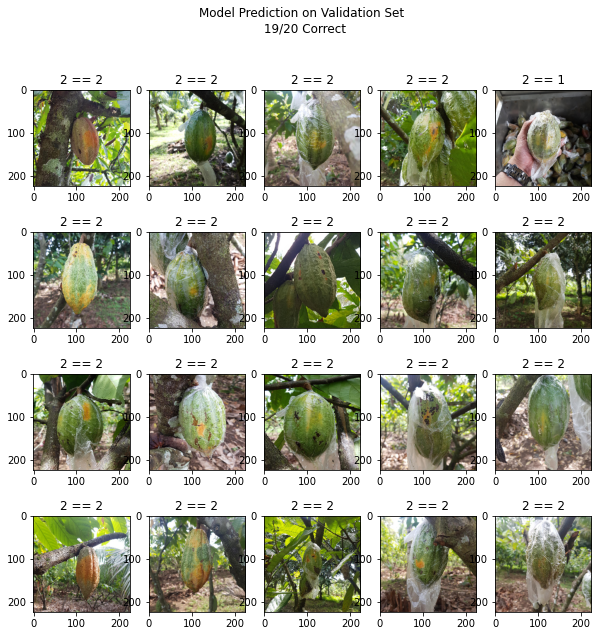

In [54]:
display_activation_graph(pod_borer_array, 2)

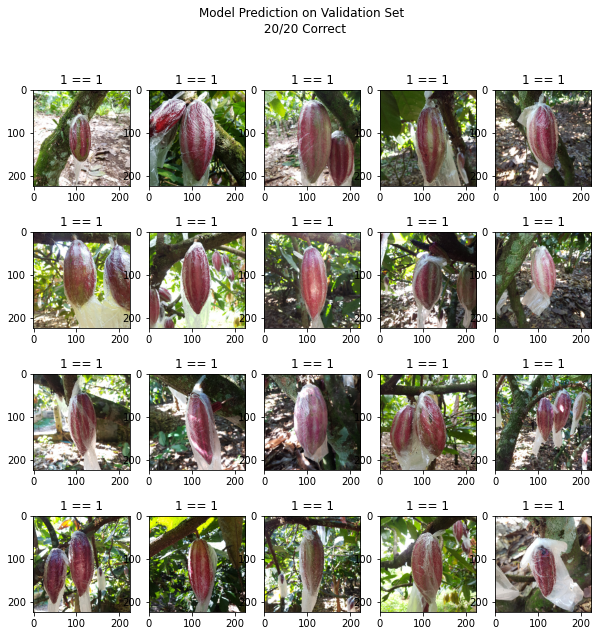

In [55]:
display_activation_graph(healthy_array, 1)

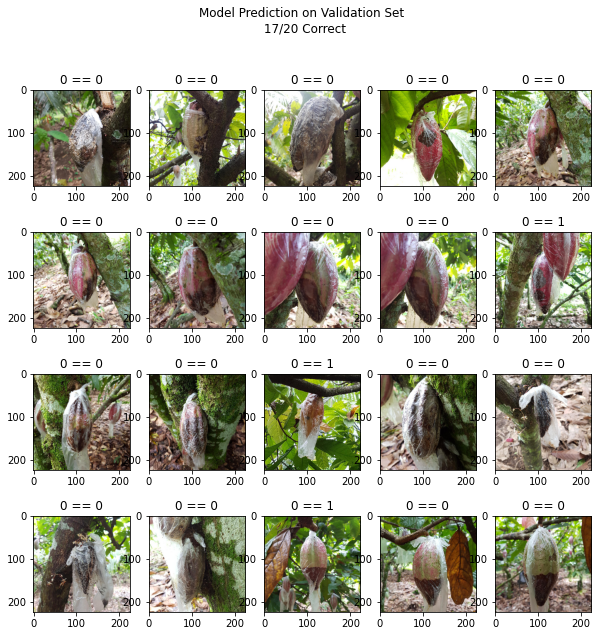

In [56]:
display_activation_graph(black_pod_array, 0)

In [38]:
import tensorflow as tf
from keras.models import load_model

best_models = tf.keras.models.load_model('./best_models/Val_Loss.h5')

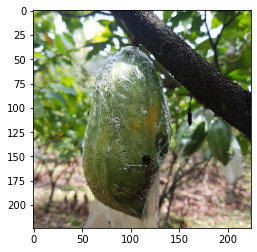

Prediction: healthy


In [65]:
from skimage import io
from keras.preprocessing import image
import numpy as np
import matplotlib.pylab as plt

disease_class = ['healthy','black_pod_rot','pod_borer']

x = image.load_img('./val_photos/pod_borer/pod_borer_13.jpg', target_size=(224, 224))
plt.imshow(x)
plt.show()

#x = image.resize(244, 244)
x = image.img_to_array(x)
x = np.expand_dims(x, axis = 0)
#x = np.array(x)
#x /= 255

result = best_models.predict(x)
result=np.argmax(0)



#plt.gray()
#a=custom[0]
        
print('Prediction:', disease_class [result])

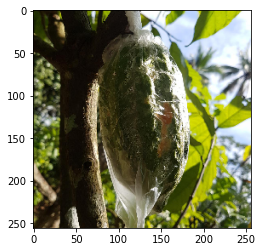

The prediction for this image is:  [0]


In [45]:
import pickle
import xgboost as xgb
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import matplotlib.pylab as plt

model_pred = pickle.load(open('V3model.pkl', 'rb'))

disease_class = ['healthy','black_pod_rot','pod_borer']
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('C:\\Users\\Administrator\\Desktop\\Cacao Dataset V3\\val\\pod_borer\\pod_borer_58.jpg', grayscale=False, target_size=(256, 256))
plt.imshow(img)
plt.show()

#show_img=image.load_img('./val_photos/healthy/healthy_10.jpg', grayscale=False, target_size=(256, 256))
img = img.resize((256, 256))
img = img_to_array(img) 
img = img.reshape( -1,256, 256,3)

#input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
predict_image = VGG_model.predict(img)
predict_image = predict_image.reshape(predict_image.shape[0], -1)
#input_img_feature=VGG_model.predict(input_img)


prediction = model_pred.predict(predict_image)

#prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name

print("The prediction for this image is: ", prediction)

#print("The actual label for this image is: ", test_labels[n])